In [27]:
using JuMP
import GLPK
import Random
import Plots

TSP with IP

In [130]:
function genereate_distance_matrix(n; random_seed = 1)
    rng = Random.MersenneTwister(random_seed)
    X = 100 * rand(rng, n)
    Y = 100 * rand(rng, n)
    d = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:n, j in 1:n]
    return X, Y, d
end

n = 8
X, Y, d = genereate_distance_matrix(n)

([23.603334566204694, 34.651701419196044, 31.27069683360675, 0.790928339056074, 48.86128300795012, 21.096820215853597, 95.1916339835734, 99.99046588986135], [25.166218303197184, 98.66663668987997, 55.57510873245724, 43.71079746096251, 42.471785049513144, 77.3223048457377, 28.11902322857298, 20.947237319807076], [0.0 74.32615900970328 … 71.64917075862188 76.50355307040174; 74.32615900970328 0.0 … 92.96262259631739 101.53550699631121; … ; 71.64917075862188 92.96262259631739 … 0.0 8.629212060552257; 76.50355307040174 101.53550699631121 … 8.629212060552257 0.0])

In [131]:
function build_tsp_model(d, n)
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x)/2)  
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], sum(x[i, i]) == 0)
    return model
end


build_tsp_model (generic function with 1 method)

In [168]:
function subtour(edges::Vector{Tuple{Int, Int}}, n)
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    println("edges is: $edges")
    loop1 = 0
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        loop1 += 1
        loop2 = 0
        while !isempty(neighbors)
            loop2 += 1
            println("loop $loop1 - $loop2")
            println("neighbors1 is: $neighbors")
            println("unvisited1 is: $unvisited")
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors = [j for (i, j) in edges if i == current && j in unvisited] # neighbors: current 주변에 아직 방문하지 않은 customers.
            println("current is: $current")
            println("neighbors2 is: $neighbors")
            println("this_cycle is: $this_cycle")
            println("unvisited2 is: $unvisited")
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
        println("shortest_subtour is: $shortest_subtour")
    end
    return shortest_subtour
end

subtour (generic function with 3 methods)

In [169]:
function selected_edges(x::Matrix{Float64}, n)
    return Tuple{Int, Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.5]
end

selected_edges (generic function with 1 method)

In [170]:
subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

subtour (generic function with 3 methods)

In [171]:
iterative_model = build_tsp_model(d, n)
optimize!(iterative_model)
time_iterated = solve_time(iterative_model)
cycle = subtour(iterative_model[:x]) # iterative_model[:x], 여기서 :x의 의미는 variable들을 의미한다. 
while 1 < length(cycle) < n
    println("Found cycle of length $(length(cycle))")
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    @constraint(
        iterative_model,
        sum(iterative_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1, # 2-d로 정의된 x[1:n, 1:n] 중에서 (i, j)에 속한 것들만 더한다. 
    )
    optimize!(iterative_model)
    global time_iterated += solve_time(iterative_model)
    global cycle = subtour(iterative_model[:x])
end

objective_value(iterative_model)

edges is: [(3, 1), (4, 1), (3, 2), (6, 2), (1, 3), (2, 3), (1, 4), (6, 4), (7, 5), (8, 5), (2, 6), (4, 6), (5, 7), (8, 7), (5, 8), (7, 8)]
loop 1 - 1
neighbors1 is: Set([5, 4, 6, 7, 2, 8, 3, 1])
unvisited1 is: Set([5, 4, 6, 7, 2, 8, 3, 1])
current is: 5
neighbors2 is: [7, 8]
this_cycle is: [5]
unvisited2 is: Set([4, 6, 7, 2, 8, 3, 1])
loop 1 - 2
neighbors1 is: [7, 8]
unvisited1 is: Set([4, 6, 7, 2, 8, 3, 1])
current is: 8
neighbors2 is: [7]
this_cycle is: [5, 8]
unvisited2 is: Set([4, 6, 7, 2, 3, 1])
loop 1 - 3
neighbors1 is: [7]
unvisited1 is: Set([4, 6, 7, 2, 3, 1])
current is: 7
neighbors2 is: Int64[]
this_cycle is: [5, 8, 7]
unvisited2 is: Set([4, 6, 2, 3, 1])
shortest_subtour is: [5, 8, 7]
loop 2 - 1
neighbors1 is: Set([4, 6, 2, 3, 1])
unvisited1 is: Set([4, 6, 2, 3, 1])
current is: 4
neighbors2 is: [1, 6]
this_cycle is: [4]
unvisited2 is: Set([6, 2, 3, 1])
loop 2 - 2
neighbors1 is: [1, 6]
unvisited1 is: Set([6, 2, 3, 1])
current is: 6
neighbors2 is: [2]
this_cycle is: [4, 6]
unvi

292.7468132521477

In [68]:
time_iterated

5.2928924560546875e-5

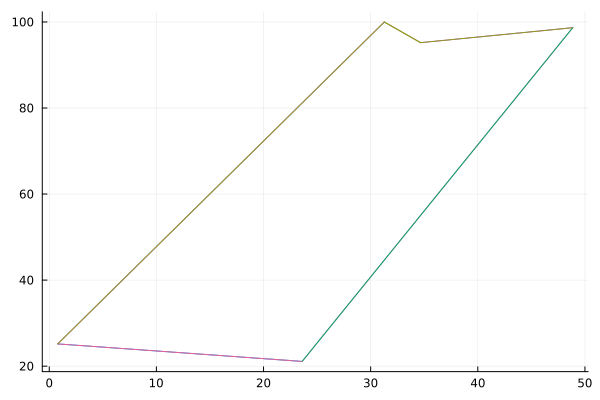

In [69]:
function plot_tour(X, Y, x)
    plot = Plots.plot()
    for (i, j) in selected_edges(x, size(x, 1))
        Plots.plot!([X[i], X[j]], [Y[i], Y[j]]; legend = false)
    end
    return plot
end

plot_tour(X, Y, value.(iterative_model[:x]))

Lazy constraint method

In [70]:
lazy_model = build_tsp_model(d, n)
function subtour_elimination_callback(cb_data)
    status = callback_node_status(cb_data, lazy_model)
    if status != MOI.CALLBACK_NODE_STATUS_INTEGER
        return 
    end
    cycle = subtour(callback_value.(cb_data, lazy_model[:x]))
    if !(1 < length(cycle) < n)
        return
    end
    println("Found cycle of length $(length(cycle))")
    S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
    con = @build_constraint(
        sum(lazy_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1,
    )
    MOI.submit(lazy_model, MOI.LazyConstraint(cb_data), con)
    return
end
set_attribute(
    lazy_model,
    MOI.LazyConstraintCallback(),
    subtour_elimination_callback,
)
optimize!(lazy_model)
objective_value(lazy_model)

206.04362696591477

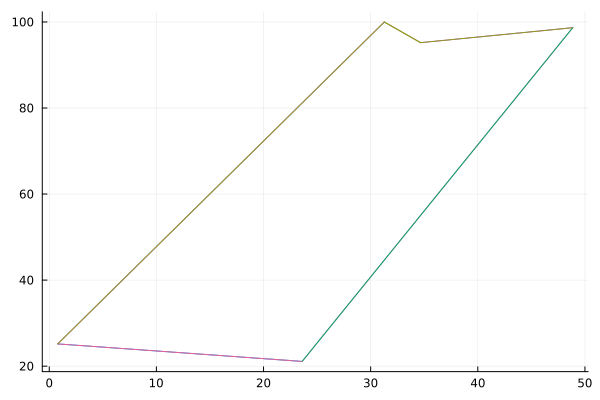

In [71]:
plot_tour(X, Y, value.(lazy_model[:x]))

In [72]:
time_lazy = solve_time(lazy_model)

0.06377410888671875

TSP with DP